In [1]:
import matplotlib.pyplot as plt
import numpy as np 
from numpy import linspace
import pandas as pd 
import seaborn as sns 
import statsmodels.api as sm
from statsmodels.graphics.api import abline_plot
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn import linear_model, preprocessing
from scipy.stats import gaussian_kde
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")
from scipy.stats import ttest_ind, chi2_contingency
from matplotlib.colors import ListedColormap

In [2]:
df = pd.read_csv('Data/02_clean_loans50k.csv', index_col=0)

In [3]:
df.head().T

,0,1,2,3,4
loanID,188861,517703,268587,579902,617630
amount,8000.0,11000.0,35000.0,20000.0,12000.0
term,36 months,36 months,36 months,60 months,60 months
rate,0.14,0.1,0.15,0.12,0.12
payment,272.07,354.89,1220.33,447.83,266.88
grade,C,B,D,C,B
employment,Warehouseman,Vice President,Owner/Attorney,Analyst,medical technician
length,3 years,10+ years,10+ years,2 years,10+ years
home,RENT,MORTGAGE,RENT,MORTGAGE,MORTGAGE
income,49966.0,50000.0,360000.0,60000.0,64000.0


**Quite a large amount of the info is text data, rather than numerical.**

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49184 entries, 0 to 49998
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   loanID       49184 non-null  int64  
 1   amount       49184 non-null  float64
 2   term         49184 non-null  object 
 3   rate         49184 non-null  float64
 4   payment      49184 non-null  float64
 5   grade        49184 non-null  object 
 6   employment   49184 non-null  object 
 7   length       49184 non-null  object 
 8   home         49184 non-null  object 
 9   income       49184 non-null  float64
 10  verified     49184 non-null  object 
 11  status       49184 non-null  object 
 12  reason       49184 non-null  object 
 13  state        49184 non-null  object 
 14  debtIncRat   49184 non-null  float64
 15  delinq2yr    49184 non-null  float64
 16  inq6mth      49184 non-null  float64
 17  openAcc      49184 non-null  float64
 18  pubRec       49184 non-null  float64
 19  revo

**I changed Source Verified to match the other entries as 'Verified'. <br> Lastly, I dropped the 'totalPaid' as this feature isn't created until after the loan is issued and cannot be used as a predictor of default**

In [5]:
df.status.value_counts()

Current    41604
Default     7580
Name: status, dtype: int64

In [6]:
percent_default = round(len(df[df.status == 'Default']) / len(df.status)  * 100,2)
print('Percent of data that is Status default', percent_default)

Percent of data that is Status default 15.41


In [7]:
df['verified'] = df['verified'].replace(['Source Verified'], 'Verified')
df = df.drop(['totalPaid'], axis=1)

**Next I wanted to check what correlations exist in the data. Since there was a 99% correlation between totalBal and totalLim, I removed the totalLim feature as it doesn't provide additional information.**

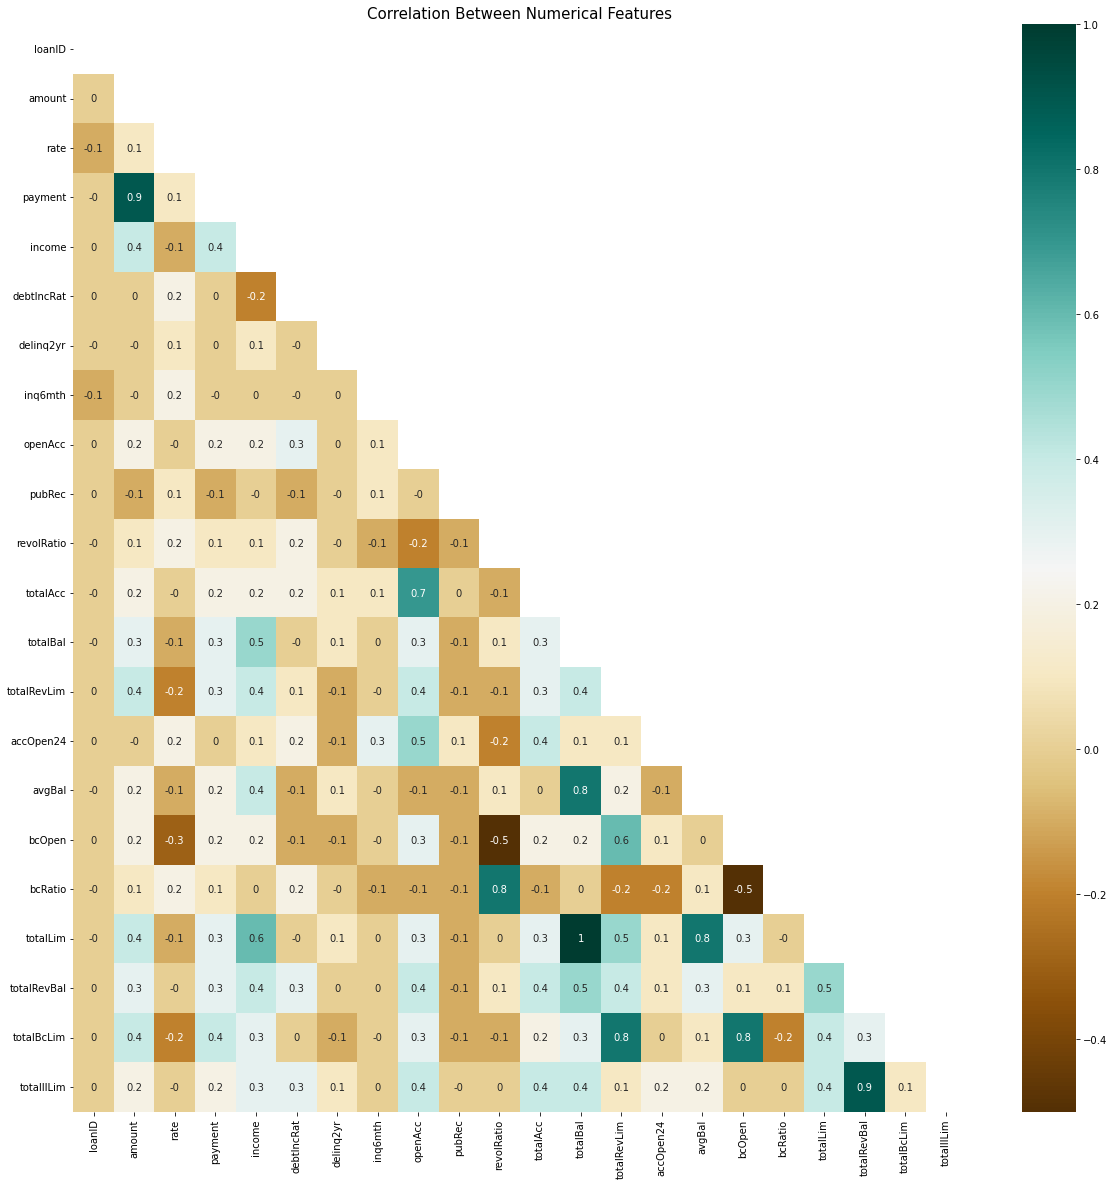

In [8]:
# Create a correlation matrix
corr = round(df.corr(), 1)

# Create a mask to hide the upper triangle of the heatmap
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True

# Plot the heatmap with the mask
plt.figure(figsize=(20, 20))
ax = sns.heatmap(corr, annot=True, cmap='BrBG', mask=mask)
plt.title('Correlation Between Numerical Features', size=15)

# Save the figure as a PNG image
plt.savefig('Images/01_Heatmap', dpi=300, bbox_inches='tight')

plt.show()

In [9]:
# Drop totalLim feature
df = df.drop(['totalLim'], axis=1)

**Confirm that loanIDs are all unqiue. Since they are, I will use the loanID as the index.**

In [10]:
# Check shape to compare against length of unique loanIDs
df.shape

(49184, 30)

In [11]:
# Confirm all loanIDs are unique
df.loanID.nunique()

49184

**Replace existing index with loanID column. Rate, payment & grade are determined by the bank after approving the loan. These are not predictive features.**

In [12]:
df = df.drop(['rate', 'payment', 'grade'], axis=1).set_index('loanID')

**I wanted to see if the employmet field could be used as a predictor. There are over 18,000 unique professions. I also looked to see how many might be duplicates by looking at any employment that contains 'nurse.' There are many that could be grouped but some are pretty different (like registered nurse vs certified nurse assistant). In the end, it's too much to figure out so I dropped that feature. I still have (employment) length so I am able to capture some of a related feature.**

In [13]:
df.employment = df.employment.str.lower()

In [14]:
df.employment.nunique()

18272

In [15]:
search_word = 'nurse'
pattern = f'.*{search_word}.*'  # regular expression pattern to match any string that contains the search_word
result = df[df['employment'].str.contains(pattern)]
result.head(10)

,amount,term,employment,length,home,income,verified,status,reason,state,...,totalAcc,totalBal,totalRevLim,accOpen24,avgBal,bcOpen,bcRatio,totalRevBal,totalBcLim,totalIlLim
loanID,,,,,,,,,,,,,,,,,,,,,
281259,10000.0,36 months,registered nurse,2 years,RENT,75000.0,Not Verified,Current,debt_consolidation,CA,...,31.0,93495.0,39900.0,2.0,4921.0,31333.00,10.7,93495.0,35100.0,101320.0
54149,18825.0,60 months,nurse,1 year,MORTGAGE,53000.0,Verified,Current,debt_consolidation,IL,...,12.0,197390.0,13600.0,5.0,28199.0,1868.00,75.4,44885.0,7600.0,44953.0
281495,17000.0,36 months,registered nurse,7 years,MORTGAGE,140000.0,Not Verified,Current,credit_card,CA,...,32.0,506667.0,47800.0,6.0,31667.0,12753.00,62.4,36045.0,33900.0,30108.0
351772,6000.0,36 months,certified nurse assistant,2 years,RENT,20000.0,Verified,Default,home_improvement,CA,...,19.0,38782.0,14000.0,8.0,2155.0,9855.00,4.3,38782.0,10300.0,35250.0
616263,8675.0,36 months,travel nurse,< 1 year,RENT,56400.0,Not Verified,Current,house,SC,...,15.0,29088.0,5800.0,2.0,2909.0,9154.93,63.2,29088.0,0.0,29997.0
214963,25000.0,36 months,reg nurse,2 years,MORTGAGE,150000.0,Verified,Current,debt_consolidation,MD,...,21.0,463748.0,31800.0,0.0,51528.0,3699.00,87.6,39625.0,29800.0,18006.0
345517,28000.0,36 months,nurse- aprn,10+ years,MORTGAGE,110000.0,Not Verified,Current,debt_consolidation,SC,...,32.0,134087.0,109200.0,1.0,7449.0,38235.00,48.1,48256.0,73700.0,14986.0
455922,23550.0,36 months,registered nurse,< 1 year,OWN,56100.0,Verified,Current,debt_consolidation,VA,...,29.0,43342.0,10600.0,3.0,8668.0,342.00,82.9,43342.0,2000.0,44928.0
397210,9000.0,36 months,public health nurse,1 year,RENT,62000.0,Verified,Current,medical,CO,...,21.0,49724.0,12300.0,2.0,4972.0,2792.00,71.5,49724.0,9800.0,61942.0


In [16]:
df = df.drop('employment', axis=1)

**Separate the features and target variable. Use chi-squared test to look see which features might make the biggest impact in when modeling later.**

In [17]:
X = df.drop('status', axis=1)
y = df['status']

In [18]:
# Perform chi-squared test for categorical features
chi_scores = []
for col in X.select_dtypes(include='object').columns:
    contingency_table = pd.crosstab(X[col], y)
    chi, pval, dof, expected = chi2_contingency(contingency_table)
    chi_scores.append([col, chi, pval])

In [19]:
# create a dataframe from the list of lists
feature_scores = pd.DataFrame(chi_scores, columns=['Feature', 'Chi2 Test', 'P-Value'])

# print the dataframe
feature_scores = feature_scores.sort_values(by='Chi2 Test', ascending=False)
feature_scores

,Feature,Chi2 Test,P-Value
0,term,400.006025,5.490641e-89
3,verified,229.201284,8.902881e-52
2,home,176.506367,4.700342e-39
4,reason,152.972930,1.412668e-26
5,state,151.043066,1.376752e-12
1,length,69.079249,1.827318e-10


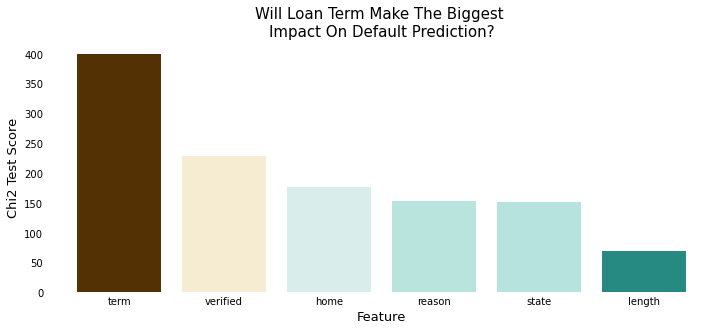

In [20]:
# Make bar chart for P-Value Top Scores
# Create a color gradient for the bar chart
color_map = plt.cm.get_cmap('BrBG_r')

# Plot the top P-Values results with a color gradient
plt.figure(figsize=(12, 6))
bars = plt.bar(feature_scores['Feature'], feature_scores['Chi2 Test'],
               color=color_map(feature_scores['Chi2 Test'] / max(feature_scores['Chi2 Test'])))
plt.xticks(range(len(feature_scores['Feature'])))
plt.xlabel('Feature', size=13)
plt.ylabel('Chi2 Test Score', size=13)
plt.title('Will Loan Term Make The Biggest \nImpact On Default Prediction?', size=15)

# Add horizontal lines behind the bars.
for i in range(1, 1):
    plt.axhline(y=i/10, color='lightblue', zorder=-1, linewidth=0.5)

# Add space between the bars
plt.subplots_adjust(bottom=0.3)

# Remove the spines of the plot & box around the legend
sns.despine(bottom=True, left=True)

# Remove the little ticks on the x-axis & y-axis
plt.tick_params(which='both', length=0)

# Save the figure as a PNG image
plt.savefig('Images/02_Top Features: Chi2', dpi=300, bbox_inches='tight')

plt.show()

**I was curious about a possible relationship between loan status and 'debtIncRat'. Looks like it is a slightly higher trend for those who default.**

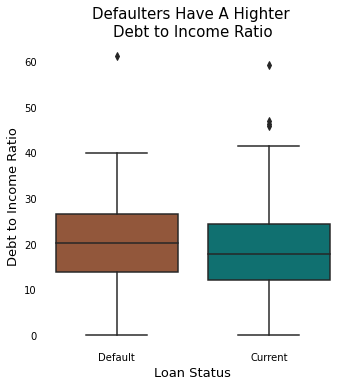

In [21]:
sns.catplot(data=df, x="status", y='debtIncRat', kind="box", 
            palette={"Default": "sienna", "Current": "teal"})

# Set the title & labels for the x-axis & y-axis
plt.title("Defaulters Have A Highter \nDebt to Income Ratio", size=15)
plt.xlabel('Loan Status', size=13)
plt.ylabel('Debt to Income Ratio', size=13)

# Remove the spines of the plot & box around the legend
sns.despine(bottom=True, left=True)

# Remove the little ticks on the x-axis & y-axis
plt.tick_params(which='both', length=0)

# Save the figure as a PNG image
plt.savefig('Images/03_Defaulter Box Plot', dpi=300, bbox_inches='tight')

plt.show()

**I wanted to see if there was a difference in defaults based on home ownership. To do this, I created a new dataframe showing the percentage of defaults for each category of home status. I was surprised to see that those who own their homes outright were in the middle. I expected them to default the least.**

In [22]:
df.home.unique()

array(['RENT', 'MORTGAGE', 'OWN'], dtype=object)

In [23]:
rent = df[(df['home'] == 'RENT') & (df['status'] == 'Default')]
mortgage = df[(df['home'] == 'MORTGAGE') & (df['status'] == 'Default')]
own = df[(df['home'] == 'OWN') & (df['status'] == 'Default')]

home_values = pd.DataFrame({'home': ['OWN', 'MORTGAGE', 'RENT'], 'default': [len(own), len(mortgage), len(rent)]})
home_totals = pd.DataFrame(df['home'].value_counts()).reset_index()
home_totals.rename(columns = {'index':'home', 'home':'count'}, inplace = True)

home_summary = pd.merge(home_values, home_totals)
home_summary['%'] = (100*home_summary['default']/home_summary['count']).round(2)
home_summary = home_summary.sort_values(by=['%'], ascending=False)

In [24]:
home_summary

,home,default,count,%
2,RENT,3473,19316,17.98
0,OWN,804,5170,15.55
1,MORTGAGE,3303,24698,13.37


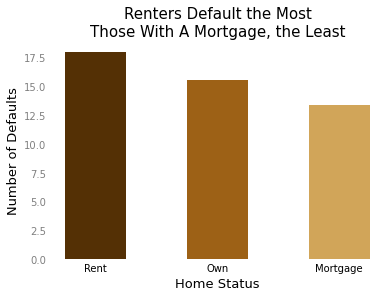

In [25]:
# Create a color gradient for the bar chart
color_map = plt.cm.get_cmap('BrBG_r')

y_pos = np.arange(len(home_summary['home']))
plt.bar(y_pos, home_summary['%'], width = .5, 
        color=color_map(home_summary['%'] / max(home_summary['%'])))

# Create a list of labels with the first letter capitalized
labels = [s.capitalize() for s in home_summary['home']]

plt.xticks(y_pos, labels)

# Set the title & labels for the x-axis & y-axis
plt.title("Renters Default the Most\nThose With A Mortgage, the Least", size=15)
plt.xlabel('Home Status', size=13)
plt.ylabel('Number of Defaults', size=13)

# Remove the spines of the plot & box around the legend
sns.despine(bottom=True, left=True)
plt.yticks(size=10, color='grey')

# Remove the little ticks on the x-axis & y-axis
plt.tick_params(which='both', length=0)

# Save the figure as a PNG image
plt.savefig('Images/04_Homeowners', dpi=300, bbox_inches='tight')

plt.show()

**I wanted to try the same experiment with the reason for the loan. I speculated that debt consolidation would be the feature with the highest percentage of defaults. Turns out, Small Business loans were highest. Debt Consolidation was the most common reason for loans, followed by Credit Cards. These are pretty similar reasons and it could be argued that joining them would make sense. If joined, together they would account for the highest amount of defaults. I created a separate drataframe and calculated the percentage of defaults per loan reason.**

In [26]:
df.reason.unique()

array(['credit_card', 'debt_consolidation', 'other', 'car',
       'home_improvement', 'vacation', 'medical', 'small_business',
       'house', 'moving', 'major_purchase', 'renewable_energy', 'wedding'],
      dtype=object)

In [27]:
default_by_reason = {reason: group[group['status'] == 'Default'] for reason, group in df.groupby('reason')}

In [28]:
credit_card = default_by_reason['credit_card']
debt_consolidation = default_by_reason['debt_consolidation']
other = default_by_reason['other']
car = default_by_reason['car']
home_improvement = default_by_reason['home_improvement']
vacation = default_by_reason['vacation']
medical = default_by_reason['medical']
small_business = default_by_reason['small_business']
house = default_by_reason['house']
moving = default_by_reason['moving']
major_purchase = default_by_reason['major_purchase']
renewable_energy = default_by_reason['renewable_energy']
wedding = default_by_reason['wedding']

In [29]:
values = pd.DataFrame({'reason': list(default_by_reason.keys()), 'defaults': [len(default_by_reason[reason]) for reason in default_by_reason]})

In [30]:
total_values = pd.DataFrame(df['reason'].value_counts()).reset_index()
total_values

,index,reason
0,debt_consolidation,29412
1,credit_card,11742
2,home_improvement,2886
3,other,2198
4,major_purchase,896
5,medical,498
6,small_business,423
7,car,376
8,moving,284
9,vacation,269


In [31]:
total_values.rename(columns = {'index':'reason', 'reason':'count'}, inplace = True)

In [32]:
reason_summary = pd.merge(values, total_values)
reason_summary['%'] = (100*reason_summary['defaults']/reason_summary['count']).round(2)
reason_summary = reason_summary.sort_values(by=['%'], ascending=False)
reason_summary.reset_index(inplace=True)

In [33]:
reason_summary.drop(['index'], axis=1)

,reason,defaults,count,%
0,small_business,112,423,26.48
1,moving,61,284,21.48
2,medical,94,498,18.88
3,house,29,162,17.90
4,vacation,47,269,17.47
5,other,370,2198,16.83
6,renewable_energy,6,36,16.67
7,debt_consolidation,4797,29412,16.31
8,major_purchase,127,896,14.17
9,home_improvement,405,2886,14.03


In [34]:
reasons = ['Wedding', 'Car', 'Credit Card', 'Home Improvement', 'Major Purchase', 'Debt Consolidation',\
           'Renewable Energy', 'Other', 'Vacation', 'House', 'Medical', 'Moving', 'Small Business']
reasons.reverse()

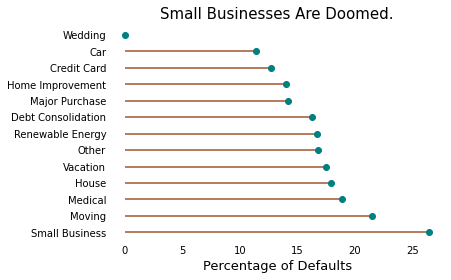

In [35]:
my_range=range(1,len(reason_summary.index)+1)

plt.hlines(y=my_range, xmin=0, xmax=reason_summary['%'], color='sienna', linestyle='solid')
plt.plot(reason_summary['%'], my_range, "o", color='teal')
plt.yticks(my_range, reasons)
plt.xlabel('Percentage of Defaults', size=13)
plt.title("Small Businesses Are Doomed.", size=15)

# Remove the spines of the plot & box around the legend
sns.despine(bottom=True, left=True)

# Remove the little ticks on the x-axis & y-axis
plt.tick_params(which='both', length=0)

# Save the figure as a PNG image
plt.savefig('Images/05_Small Businesses', dpi=300, bbox_inches='tight')

plt.show()

**I separated Current & Default into their own dataframes and created samples of 1000 from each for easier visualization. I did a quick histogram of the separated dataframes to compare to each other. Most of the distributions have very distinct right tails showing outliers in the data.**

In [36]:
default = df[df['status']=='Default']
current = df[df['status']=='Current']

default_sample = default.sample(1000)
current_sample = current.sample(1000)
df_sample=df.sample(1000)

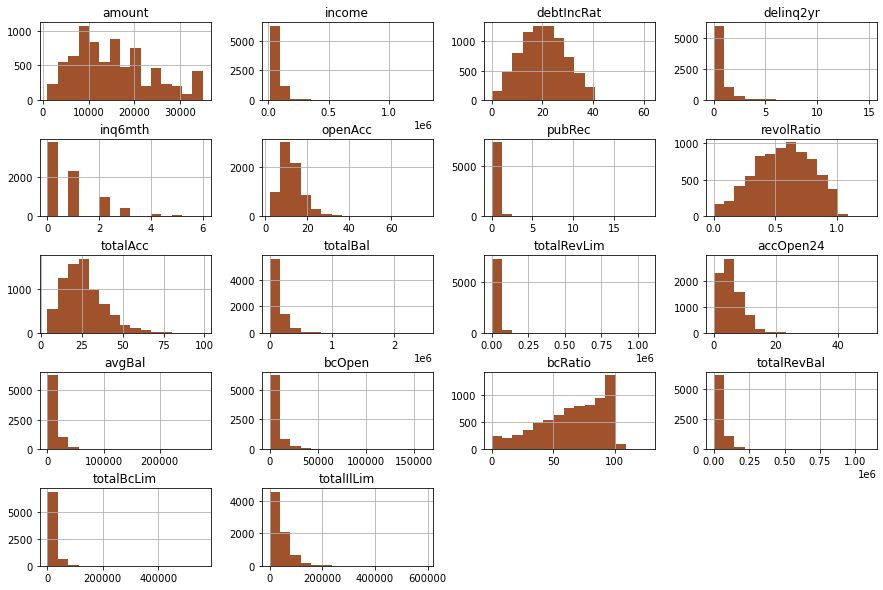

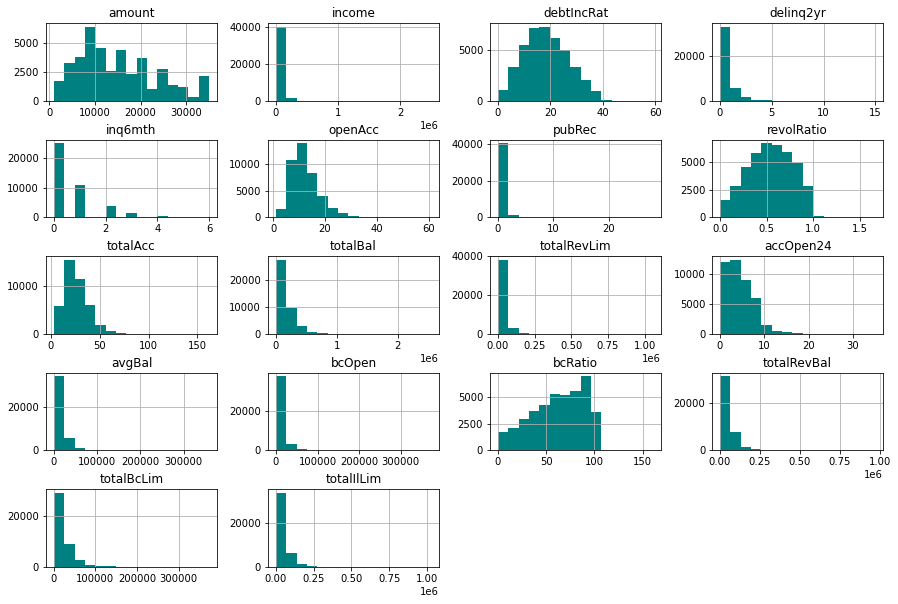

In [37]:
figsize=(10, 10)
default.hist(figsize=(15, 10), bins=15, color='sienna')
plt.subplots_adjust(hspace=0.5)
current.hist(figsize=(15, 10), bins=15, color='teal')
plt.subplots_adjust(hspace=0.5)
plt.show()

**I tried using describe on each of the newly created dataframes and then subtracted them from each other to see if there were any large differences. Because the data is scaled very differently, it was hard to easily see what differences might be important. And beyond that, because the data is not normally distributed, these metrics are not as helpful.**

In [38]:
default_info = default.describe()
current_info = current.describe()

default_info = default_info.drop('count')
current_info = current_info.drop('count')

In [39]:
default_info.subtract(current_info, axis = 1).T

,mean,std,min,25%,50%,75%,max
amount,394.428188,-151.896408,0.0,1200.0000,925.00,0.0000,0.00
income,-8282.249999,-7977.488842,4796.0,-5000.0000,-5000.00,-10583.2500,-1200000.00
debtIncRat,1.973283,0.265429,0.0,1.8075,2.37,2.2225,2.02
delinq2yr,0.024711,0.057411,0.0,0.0000,0.00,0.0000,0.00
inq6mth,0.219475,0.131919,0.0,0.0000,1.00,0.0000,0.00
openAcc,0.328932,0.322006,1.0,0.0000,0.00,0.0000,15.00
pubRec,0.039927,0.037349,0.0,0.0000,0.00,0.0000,-9.00
revolRatio,0.021754,-0.005397,0.0,0.0300,0.02,0.0200,-0.41
totalAcc,0.111620,0.453497,1.0,0.0000,0.00,0.0000,-63.00
totalBal,-26659.003629,-18821.955463,0.0,-2661.5000,-24105.50,-45432.2500,-65643.00


**I looked at the difference between the 50th percentiles (medians). Looks like there are some notable features that might be relevant later on.**

In [40]:
median_diffs = pd.DataFrame(default.median() - current.median())
median_diffs.columns = ['Diffs']
median_diffs.T

,amount,income,debtIncRat,delinq2yr,inq6mth,openAcc,pubRec,revolRatio,totalAcc,totalBal,totalRevLim,accOpen24,avgBal,bcOpen,bcRatio,totalRevBal,totalBcLim,totalIlLim
Diffs,925.0,-5000.0,2.37,0.0,1.0,0.0,0.0,0.02,0.0,-24105.5,-3500.0,1.0,-2003.5,-1346.5,4.3,-591.0,-3200.0,210.0


**I looked at why people were getting a loan vs. their income. I used loan status to further separate the data on the plot.**

In [41]:
df.columns

Index(['amount', 'term', 'length', 'home', 'income', 'verified', 'status',
       'reason', 'state', 'debtIncRat', 'delinq2yr', 'inq6mth', 'openAcc',
       'pubRec', 'revolRatio', 'totalAcc', 'totalBal', 'totalRevLim',
       'accOpen24', 'avgBal', 'bcOpen', 'bcRatio', 'totalRevBal', 'totalBcLim',
       'totalIlLim'],
      dtype='object')

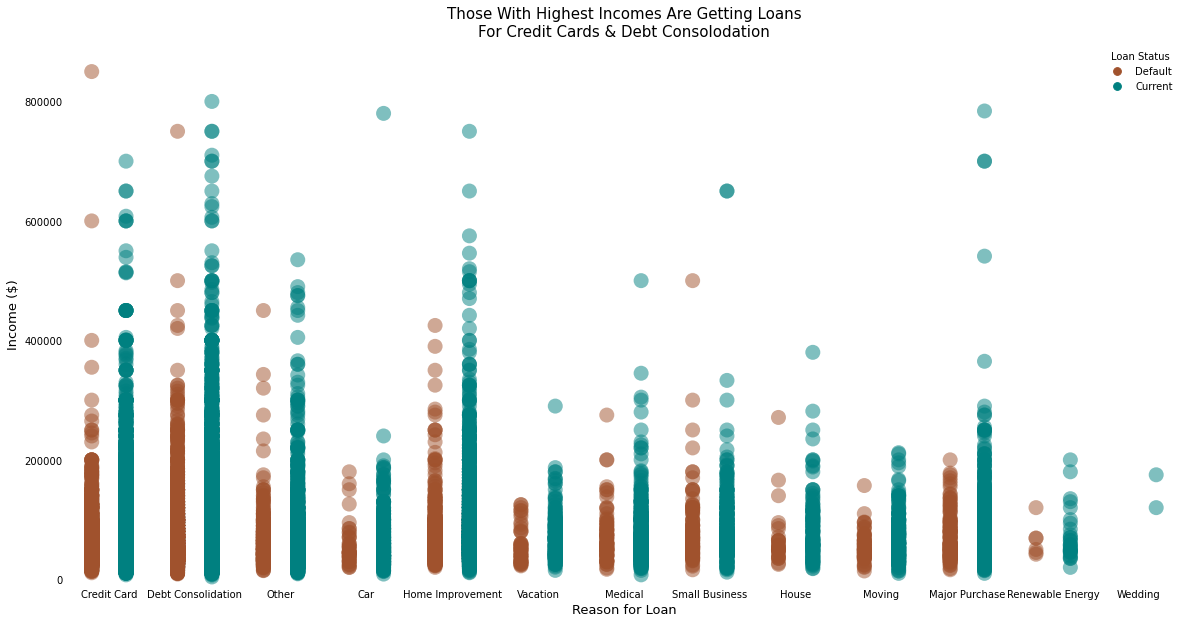

In [42]:
# Replace underscores with spaces and capitalize each word in 'reason' column
df['reason'] = df['reason'].str.replace('_', ' ').str.title()

# Create a figure and axis with a specified size
fig, ax = plt.subplots(figsize=(20,10))

# Create a custom color palette
custom_palette = {'Current': 'teal', 'Default': 'sienna'}

# Create a strip plot showing the relationship between the modified 'reason' column and the 'income' column, 
# with the 'status' column as the hue, using the custom palette
sns.stripplot(x='reason', y="income", data=df, hue='status', alpha=0.5, palette=custom_palette, jitter=False, size=15, dodge=True, marker='o')

# Set the y-axis limits
plt.ylim(-10000,900000)

# Set the title & labels for the x-axis & y-axis
plt.title('Those With Highest Incomes Are Getting Loans\nFor Credit Cards & Debt Consolodation', loc='center', size=15)
plt.xlabel('Reason for Loan', size=13)
plt.ylabel('Income ($)', size=13)

# Remove the spines of the plot & box around the legend
sns.despine(bottom=True, left=True)
plt.legend(frameon=False, title='Loan Status')

# Remove the little ticks on the x-axis & y-axis
plt.tick_params(which='both', length=0)

# Save the figure as a PNG image with a specified resolution and tight bounding box
plt.savefig('Images/06_Reason for Loan versus Income', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

**I used sampled data to scatter plot the Revolving Ratio against the Total Credit Limits of Credit Cards and added a regression line for both Current & Default loans.**

In [43]:
x1, y1 = default_sample['totalIlLim'], default_sample['avgBal']
x2, y2 = current_sample['totalIlLim'], current_sample['avgBal']

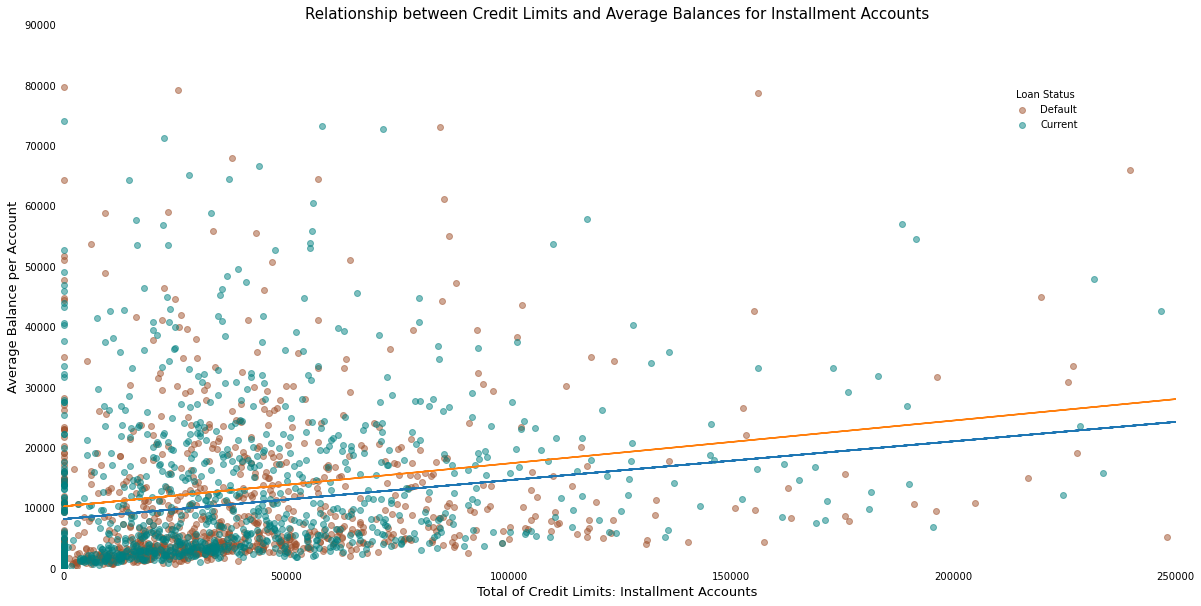

In [44]:
# Create a figure and axis with a specified size
fig, ax = plt.subplots(figsize=(20,10))

# Create scatter plots for two datasets
ax.scatter(x1, y1, color='sienna', label='Default', alpha=.5)
ax.scatter(x2, y2, color='teal', label = 'Current', alpha=.5)

# Perform linear regression for each dataset and plot the resulting line
m1, b1 = np.polyfit(x1, y1, 1)
plt.plot(x1, m1*x1+b1)

m2, b2 = np.polyfit(x2, y2, 1)
plt.plot(x2, m2*x2+b2)

# # Set the y-axis limits
plt.xlim(-1000,250000)
plt.ylim(0,90000)

# Set the title of the plot and labels for the x-axis & y-axis
ax.set_title('Relationship between Credit Limits and Average Balances for Installment Accounts', size=15)
ax.set_xlabel('Total of Credit Limits: Installment Accounts', size=13)
ax.set_ylabel('Average Balance per Account', size=13)

# Remove the spines of the plot
sns.despine(bottom=True, left=True)
plt.legend(frameon=False, title='Loan Status', loc=(0.85,0.80))

# Remove the little ticks on the x-axis & y-axis
plt.tick_params(which='both', length=0)

# Save the figure as a PNG image with a specified resolution and tight bounding box
plt.savefig('Images/07_Revolving Ratio vs Payment', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

**I wanted to sort the defaults by state to see if any states in particular had a higher percentage of defaults. I decided to regroup the states by quartiles. This can be helpful during preprocessing when categorical features are encoded.**

In [45]:
df['status_num'] = df['status']
df['status_num'] = df['status_num'].replace(['Current', 'Default'], [0, 1])

In [46]:
df.status_num = df.status_num
state_counts = df.groupby('state').agg({'status_num': 'sum'}).reset_index()

state_num = df.groupby('state')['state'].count().reset_index(name='count')

state_summary = pd.merge(state_counts, state_num, on='state')
state_summary.columns=['state', 'number_of_defaults', 'total_loans']
state_summary['%_of_defaults'] = state_summary['number_of_defaults']/state_summary['total_loans']
state_summary = state_summary.sort_values(by=['%_of_defaults'], ascending=False)

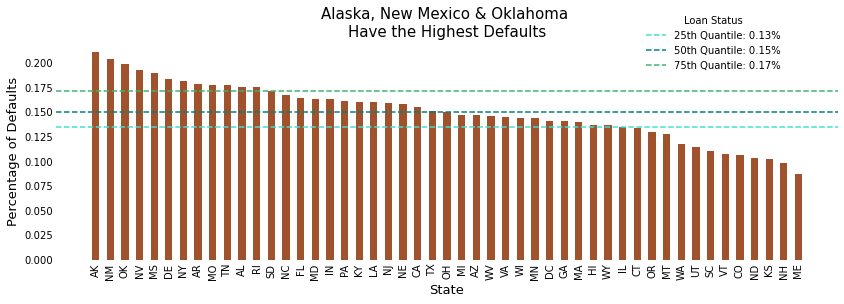

In [47]:
# Calculate the quartiles
quantile_25 = state_summary['%_of_defaults'].quantile(0.25)
quantile_50 = state_summary['%_of_defaults'].quantile(0.50)
quantile_75 = state_summary['%_of_defaults'].quantile(0.75)


# Create the bar plot
plt.figure(figsize=(14, 4))

y_pos = np.arange(len(state_summary['state']))

plt.bar(y_pos, state_summary['%_of_defaults'], width = .5, color='sienna')
plt.xlabel('State', size=13)
plt.ylabel('Percentage of Defaults', size=13)
plt.xticks(y_pos, state_summary['state'], rotation=90)
plt.title('Alaska, New Mexico & Oklahoma \nHave the Highest Defaults', size=15)

# Add the horizontal dashed line at the quantiles
plt.axhline(quantile_25, linestyle='--', color='turquoise', label=f'25th Quantile: {quantile_25:.2f}%')
plt.axhline(quantile_50, linestyle='--', color='teal', label=f'50th Quantile: {quantile_50:.2f}%')
plt.axhline(quantile_75, linestyle='--', color='mediumseagreen', label=f'75th Quantile: {quantile_75:.2f}%')

# Change the order of the legend
handles, labels = plt.gca().get_legend_handles_labels()
order = [2, 1, 0]

# Remove the spines of the plot
sns.despine(bottom=True, left=True)
plt.legend(frameon=False, title='Loan Status', loc=(0.75,0.85))

# Remove the little ticks on the x-axis & y-axis
plt.tick_params(which='both', length=0)

# Save the figure as a PNG image
plt.savefig('Images/08_State Defaults', dpi=300, bbox_inches='tight')

plt.show()

**A quick glance at the states with high defaults made me curious what the correlation was with math scores in that state. I was able to find a dataset with math scores by state so I cleaned it up and merged it the the state_summary dataframe. Not particularly useful but it is interesting nonetheless.**

In [48]:
test_scores_df = pd.read_csv('data/state_education.csv', index_col=0)
test_scores_df.sample(5)

,state,math_score,reading_score
9,FL,279.0,267.0
40,SC,275.0,260.0
31,NM,269.0,256.0
34,ND,288.0,265.0
5,CA,277.0,263.0


In [49]:
state_summary = pd.merge(state_summary, test_scores_df, on='state')
state_summary.sample(5)

,state,number_of_defaults,total_loans,%_of_defaults,math_score,reading_score
14,FL,545,3309,0.164702,279.0,267.0
0,AK,24,114,0.210526,277.0,258.0
16,IN,143,878,0.162870,288.0,272.0
27,WV,39,267,0.146067,273.0,259.0
25,MI,199,1352,0.147189,280.0,265.0


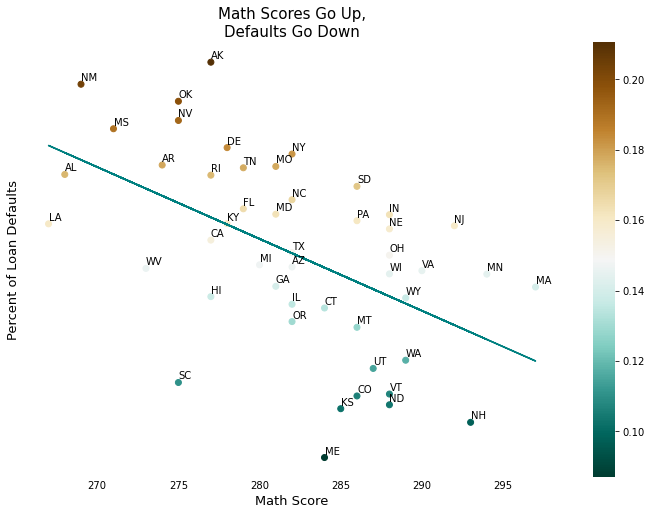

In [50]:
# Create the bar plot
plt.figure(figsize=(12, 8))

x = state_summary['math_score']
y = state_summary['%_of_defaults']
z = state_summary['%_of_defaults']  # use %_of_defaults as the color variable

# Define the colormap to use
cmap = plt.cm.get_cmap('BrBG_r')

# Create the scatter plot with the color gradient
plt.scatter(x, y, c=z, cmap=cmap)
cbar = plt.colorbar()
cbar.outline.set_edgecolor('none')  # remove the black box around the colorbar

# Label the x-axis and y-axis and give the plot a title
plt.xlabel('Math Score', size=13)
plt.ylabel('Percent of Loan Defaults', size=13)
plt.title('Math Scores Go Up,\nDefaults Go Down', size=15)

# Fit a linear regression line to the data
coefficients = np.polyfit(x, y, 1)
p = np.poly1d(coefficients)

# Generate new y-values based on the regression line
trend_y = p(x)

# Plot the regression line
plt.plot(x, trend_y, color='teal')

# Remove the spines of the plot
sns.despine(bottom=True, left=True)

# Remove the little ticks on the x-axis & y-axis
plt.tick_params(which='both', length=0)
plt.yticks([])

# Add state labels with a slight offset
for i, state in enumerate(state_summary['state']):
    plt.annotate(state, 
                 xy=(state_summary['math_score'][i], state_summary['%_of_defaults'][i]),
                 xytext=(state_summary['math_score'][i]+0.002, state_summary['%_of_defaults'][i]+0.001))

# Save the figure as a PNG image
plt.savefig('Images/09_Math Scores', dpi=300, bbox_inches='tight')

plt.show()

**Below I grouped the states by quartiles.**

In [51]:
# Create the four groups using cut()
state_summary['group'] = pd.cut(state_summary['%_of_defaults'], 
                                bins=[0, quantile_25, quantile_50, quantile_75, 100], 
                                labels=['Quartile_1', 'Quartile_2', 'Quartile_3', 'Quartile_4'])

# Group the data by the quartile
groups = state_summary.groupby('group')['state'].apply(list)

df['state'] = df['state'].replace(groups['Quartile_1'], 'Quartile_1')
df['state'] = df['state'].replace(groups['Quartile_2'], 'Quartile_2')
df['state'] = df['state'].replace(groups['Quartile_3'], 'Quartile_3')
df['state'] = df['state'].replace(groups['Quartile_4'], 'Quartile_4')

In [52]:
# Confirm states are not quartile categories.
df.state.unique()

array(['Quartile_3', 'Quartile_4', 'Quartile_2', 'Quartile_1', 'DC'],
      dtype=object)

**I tried another scatter plot to look for any patterns in the data. I plotted the Total Number of Credit Lines against the Debt to Income Ratio.**

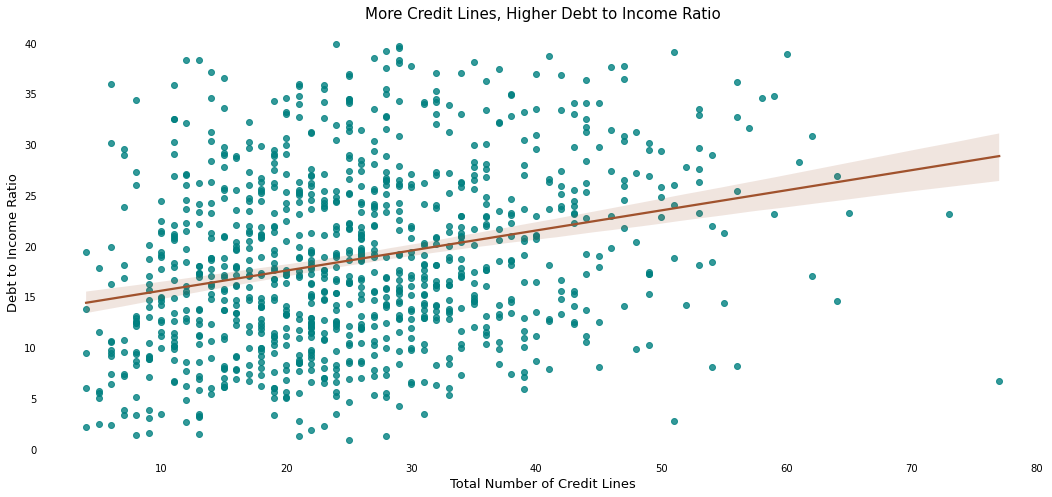

In [53]:
# Set the size of the figure
plt.figure(figsize=(18, 8))

# Plot 'totalAcc' on the x-axis and 'debtIncRat' on the y-axis using data from df_sample
sns.regplot(x='totalAcc', y='debtIncRat', data=df_sample, color='teal', line_kws={'color': 'sienna'})

# Set the title & labels for the x-axis and y-axis
plt.title('More Credit Lines, Higher Debt to Income Ratio', size=15)
plt.xlabel('Total Number of Credit Lines', size=13)
plt.ylabel('Debt to Income Ratio', size=13)

# Remove the spines of the plot
sns.despine(bottom=True, left=True)

# Remove the little ticks on the x-axis & y-axis
plt.tick_params(which='both', length=0)

# Save the figure as a PNG image
plt.savefig('Images/10_Total Credit Lines vs Debt to Income Ratio', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

**I used a histogram to plot the number of records across the debtIncRat (debt to income ratio). By splitting Default & Current, I'm able to see a trend of where current loans outnumber defaults at the lower debtIncRat and then defaults outnumber currents at the high debIncRat. It's hard to see so I tried to mirror the plot.**

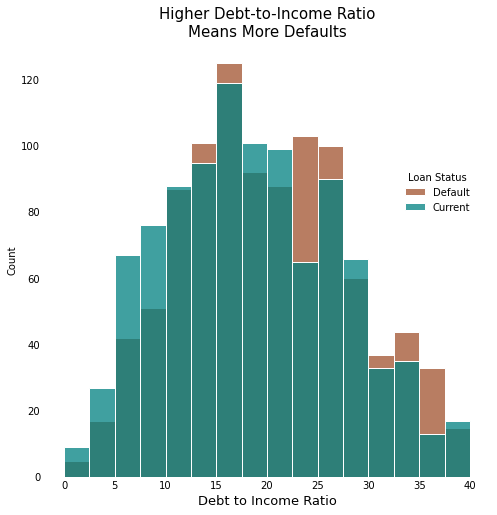

In [54]:
plt.figure(figsize=(8, 8)) 

# Set the bin edges manually
bin_edges = np.arange(0, 41, 2.5)

# Create two histograms with different colors for the "default" and "current" samples
sns.histplot(data=default_sample, x="debtIncRat", color='sienna', label='Default', bins=bin_edges, edgecolor='white')
sns.histplot(data=current_sample, x="debtIncRat", color='teal', label='Current', bins=bin_edges, edgecolor='white')

# Add a legend to the plot
plt.legend()

# Set the title, x-axis label, and y-axis label of the plot
plt.title('Higher Debt-to-Income Ratio\nMeans More Defaults', size=15)
plt.xlabel('Debt to Income Ratio', size=13)
# plt.ylabel('Number of Defaults', size=13)

# Remove the spines of the plot
sns.despine(bottom=True, left=True)
plt.legend(frameon=False, title='Loan Status', loc=(0.80,0.60))

# Remove the little ticks on the x-axis & y-axis
plt.tick_params(which='both', length=0)

# Save the plot as a PNG image
plt.savefig('Images/11_Stacked Bars', dpi=300, bbox_inches='tight')

# Display the plot
plt.show()

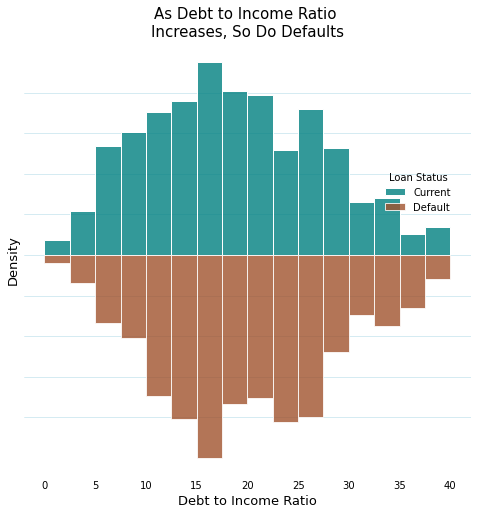

In [55]:
# Define bin edges
bin_edges = np.arange(0, 41, 2.5)

# Create a figure object with specified dimensions
plt.figure(figsize=(8, 8)) 

# Plot a histogram for current status using seaborn's histplot function
sns.histplot(current_sample.debtIncRat, stat="density", bins=bin_edges, color='teal',
             label='Current', edgecolor='white', alpha=0.8)

# Compute heights and bins for default status histogram
heights, bins = np.histogram(default_sample.debtIncRat, density=True, bins=bin_edges)
heights *= -1
bin_width = np.diff(bins)[0]
bin_pos = bins[:-1] + bin_width / 2

# Plot the default status histogram using matplotlib's bar function
plt.bar(bin_pos, heights, width=bin_width, color='sienna', label='Default', edgecolor='white', alpha=0.8)

# Set the title, x=axis label & y-axis label
plt.title('As Debt to Income Ratio \nIncreases, So Do Defaults', size=15)
plt.xlabel('Debt to Income Ratio', size=13)
plt.ylabel('Density', size=13)

# Remove the spines of the plot & the y tick labesl
sns.despine(bottom=True, left=True)
plt.yticks([])

# Remove the little ticks on the x-axis & y-axis
plt.tick_params(which='both', length=0)

for i in range(-40, 50, 10):
    plt.axhline(y=i/1000, color='lightblue', zorder=-1, linewidth=0.5)

# Save the plot as a PNG image
plt.savefig('Images/12_Butterfly', dpi=300, bbox_inches='tight')

# Show the plot & legend
plt.legend(frameon=False, title='Loan Status', loc=(0.80,0.60))
plt.show()

In [56]:
#Remove status_num column. Data will be encoded in pre-processing.
df = df.drop('status_num', axis=1)

In [57]:
df.to_csv('Data/03_eda_loans50k.csv') 